In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
from LSTMbis import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time

import pdb

torch.manual_seed(1)

In [2]:
import os
data = {}
a=0
for j in range(1,4):
    for i in os.listdir('./data_linear_augm/%s'%j):
        if i.endswith('.txt'):
            a = a+1
            data['%s'%a] = pd.read_csv('data_linear_augm/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ')

In [4]:
a = 0
inputs = np.zeros([len(data),20])
gt = np.zeros([len(data),20])
in_coord = np.zeros([len(data),20])
gt_coord = np.zeros([len(data),22])

for i in data:
    inputs[a,:,:] = np.array(data['%s'%i].loc[0:9,['Vx','Vy']])
    gt[a,:,:] = np.array(data['%s'%i].loc[10:19,['Vx','Vy']])
    in_coord[a,:,:] = np.array(data['%s'%i].loc[0:9,['x','y']])
    gt_coord[a,:,:] = np.array(data['%s'%i].loc[9:19,['x','y']])
    a +=1

In [5]:
vector = np.zeros((len(vector_speed),2*len(vector_speed[0])))
x = np.zeros((len(vector_speed),18))
y = np.zeros((len(vector_speed),18))
x_train = np.zeros((len(vector_speed)-20,18))
Y_train = np.zeros((len(vector_speed)-20,18))
x_val = np.zeros((20,18))
y_val = np.zeros((20,18))

for i in range(len(vector_speed)):
    vector[i][:] = np.reshape(vector_speed[i][:][:],2*19,'C')
for i in range(len(vector)):
    x[i][:] = vector[i][:18]
    y[i][:] = vector[i][20:38]

mask = list(range(len(vector)-20, len(vector)))
x_val = x[mask]
y_val = y[mask]
mask = list(range(len(vector)-20))
x_train = x[mask]
y_train = y[mask]

x_train,y_train = torch.from_numpy(x_train).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.FloatTensor)
x_val,y_val = torch.from_numpy(x_val).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.FloatTensor)

x_train = x_train.unsqueeze(1) # add 1 dimension to the training set
y_train = y_train.unsqueeze(1) # add 1 dimension to the training set
x_val = x_val.unsqueeze(1) # add 1 dimension to the validation set
y_val = y_val.unsqueeze(1) # add 1 dimension to the validation set

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)

traindataset = utils.TensorDataset(x_train, y_train)
trainloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

valdataset = utils.TensorDataset(x_val, y_val)
valloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

Train data shape:  torch.Size([125, 1, 18])
Train labels shape:  torch.Size([125, 1, 18])
Validation data shape:  torch.Size([20, 1, 18])
Validation labels shape:  torch.Size([20, 1, 18])


In [6]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=1, n_output=None):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        
        self.conv1 = nn.Conv1d(n_input_channels,8,5,padding=2)
        self.conv2 = nn.Conv1d(8,30,3,padding=1)
        self.conv3 = nn.Conv1d(30,40,3,padding=1)
        self.conv3_bn = nn.BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True)
     
        self.fc1 = nn.Linear(9*2 * 40, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 18)
        
        
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Variable `x` with `x.view`.                                                  #
        ################################################################################
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = x.view(-1, 9*2 * 40) # in order to reshape the tensor for as many columns we need
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def predict(self, x):
        return self.forward(x)

/Users/4romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/20.. Loss: 0.6133.. Test accuracy: 0.0380.. 0.0547 s/batch  steps 1.0000
Epoch: 1/20.. Loss: 0.2411.. Test accuracy: 0.0367.. 0.0100 s/batch  steps 2.0000
Epoch: 1/20.. Loss: 0.8234.. Test accuracy: 0.0462.. 0.0102 s/batch  steps 3.0000
Epoch: 1/20.. Loss: 0.8162.. Test accuracy: 0.0145.. 0.0101 s/batch  steps 4.0000
Epoch: 1/20.. Loss: 0.4252.. Test accuracy: 0.0161.. 0.0079 s/batch  steps 5.0000
Epoch: 1/20.. Loss: 1.0390.. Test accuracy: 0.0284.. 0.0109 s/batch  steps 6.0000
Epoch: 1/20.. Loss: 0.5160.. Test accuracy: 0.0315.. 0.0108 s/batch  steps 7.0000
Epoch: 1/20.. Loss: 0.5897.. Test accuracy: 0.0325.. 0.0112 s/batch  steps 8.0000
Epoch: 1/20.. Loss: 0.9377.. Test accuracy: 0.0121.. 0.0103 s/batch  steps 9.0000
Epoch: 1/20.. Loss: 0.5754.. Test accuracy: 0.0243.. 0.0089 s/batch  steps 10.0000
Epoch: 1/20.. Loss: 0.1971.. Test accuracy: 0.0318.. 0.0096 s/batch  steps 11.0000
Epoch: 1/20.. Loss: 0.2477.. Test accuracy: 0.0086.. 0.0102 s/batch  steps 12.0000
Epoch: 1/20..

Epoch: 5/20.. Loss: 0.1278.. Test accuracy: 0.0373.. 0.0096 s/batch  steps 102.0000
Epoch: 5/20.. Loss: 0.0480.. Test accuracy: 0.0127.. 0.0100 s/batch  steps 103.0000
Epoch: 5/20.. Loss: 0.0184.. Test accuracy: 0.0157.. 0.0081 s/batch  steps 104.0000
Epoch: 5/20.. Loss: 0.0498.. Test accuracy: 0.0170.. 0.0102 s/batch  steps 105.0000
Epoch: 5/20.. Loss: 0.0471.. Test accuracy: 0.0177.. 0.0096 s/batch  steps 106.0000
Epoch: 5/20.. Loss: 0.0351.. Test accuracy: 0.0180.. 0.0088 s/batch  steps 107.0000
Epoch: 5/20.. Loss: 0.0243.. Test accuracy: 0.0329.. 0.0111 s/batch  steps 108.0000
Epoch: 5/20.. Loss: 0.0178.. Test accuracy: 0.0128.. 0.0099 s/batch  steps 109.0000
Epoch: 5/20.. Loss: 0.0253.. Test accuracy: 0.0096.. 0.0088 s/batch  steps 110.0000
Epoch: 5/20.. Loss: 0.0407.. Test accuracy: 0.0339.. 0.0084 s/batch  steps 111.0000
Epoch: 5/20.. Loss: 0.0621.. Test accuracy: 0.0137.. 0.0096 s/batch  steps 112.0000
Epoch: 5/20.. Loss: 0.0463.. Test accuracy: 0.0075.. 0.0100 s/batch  steps 1

Epoch: 9/20.. Loss: 0.0292.. Test accuracy: 0.0218.. 0.0117 s/batch  steps 202.0000
Epoch: 9/20.. Loss: 0.0465.. Test accuracy: 0.0099.. 0.0109 s/batch  steps 203.0000
Epoch: 9/20.. Loss: 0.0434.. Test accuracy: 0.0263.. 0.0151 s/batch  steps 204.0000
Epoch: 9/20.. Loss: 0.0127.. Test accuracy: 0.0138.. 0.0094 s/batch  steps 205.0000
Epoch: 9/20.. Loss: 0.0507.. Test accuracy: 0.0220.. 0.0100 s/batch  steps 206.0000
Epoch: 9/20.. Loss: 0.0962.. Test accuracy: 0.0310.. 0.0102 s/batch  steps 207.0000
Epoch: 9/20.. Loss: 0.0250.. Test accuracy: 0.0130.. 0.0130 s/batch  steps 208.0000
Epoch: 9/20.. Loss: 0.1770.. Test accuracy: 0.0168.. 0.0122 s/batch  steps 209.0000
Epoch: 9/20.. Loss: 0.0204.. Test accuracy: 0.0330.. 0.0141 s/batch  steps 210.0000
Epoch: 9/20.. Loss: 0.0412.. Test accuracy: 0.0201.. 0.0111 s/batch  steps 211.0000
Epoch: 9/20.. Loss: 0.0462.. Test accuracy: 0.0208.. 0.0122 s/batch  steps 212.0000
Epoch: 9/20.. Loss: 0.0927.. Test accuracy: 0.0311.. 0.0129 s/batch  steps 2

Epoch: 13/20.. Loss: 0.0573.. Test accuracy: 0.0367.. 0.0125 s/batch  steps 302.0000
Epoch: 13/20.. Loss: 0.0370.. Test accuracy: 0.0324.. 0.0109 s/batch  steps 303.0000
Epoch: 13/20.. Loss: 0.0140.. Test accuracy: 0.0153.. 0.0095 s/batch  steps 304.0000
Epoch: 13/20.. Loss: 0.0427.. Test accuracy: 0.0271.. 0.0095 s/batch  steps 305.0000
Epoch: 13/20.. Loss: 0.0359.. Test accuracy: 0.0296.. 0.0095 s/batch  steps 306.0000
Epoch: 13/20.. Loss: 0.0302.. Test accuracy: 0.0149.. 0.0107 s/batch  steps 307.0000
Epoch: 13/20.. Loss: 0.0142.. Test accuracy: 0.0305.. 0.0104 s/batch  steps 308.0000
Epoch: 13/20.. Loss: 0.0786.. Test accuracy: 0.0064.. 0.0100 s/batch  steps 309.0000
Epoch: 13/20.. Loss: 0.0441.. Test accuracy: 0.0228.. 0.0102 s/batch  steps 310.0000
Epoch: 13/20.. Loss: 0.0328.. Test accuracy: 0.0092.. 0.0099 s/batch  steps 311.0000
Epoch: 13/20.. Loss: 0.0247.. Test accuracy: 0.0128.. 0.0102 s/batch  steps 312.0000
Epoch: 13/20.. Loss: 0.0206.. Test accuracy: 0.0161.. 0.0102 s/ba

Epoch: 17/20.. Loss: 0.0350.. Test accuracy: 0.0254.. 0.0109 s/batch  steps 402.0000
Epoch: 17/20.. Loss: 0.0102.. Test accuracy: 0.0226.. 0.0104 s/batch  steps 403.0000
Epoch: 17/20.. Loss: 0.0805.. Test accuracy: 0.0231.. 0.0105 s/batch  steps 404.0000
Epoch: 17/20.. Loss: 0.0228.. Test accuracy: 0.0214.. 0.0102 s/batch  steps 405.0000
Epoch: 17/20.. Loss: 0.0353.. Test accuracy: 0.0381.. 0.0099 s/batch  steps 406.0000
Epoch: 17/20.. Loss: 0.0829.. Test accuracy: 0.0131.. 0.0101 s/batch  steps 407.0000
Epoch: 17/20.. Loss: 0.0193.. Test accuracy: 0.0138.. 0.0095 s/batch  steps 408.0000
Epoch: 17/20.. Loss: 0.0215.. Test accuracy: 0.0219.. 0.0112 s/batch  steps 409.0000
Epoch: 17/20.. Loss: 0.0233.. Test accuracy: 0.0122.. 0.0094 s/batch  steps 410.0000
Epoch: 17/20.. Loss: 0.0066.. Test accuracy: 0.0223.. 0.0096 s/batch  steps 411.0000
Epoch: 17/20.. Loss: 0.0760.. Test accuracy: 0.0193.. 0.0109 s/batch  steps 412.0000
Epoch: 17/20.. Loss: 0.0345.. Test accuracy: 0.0055.. 0.0101 s/ba

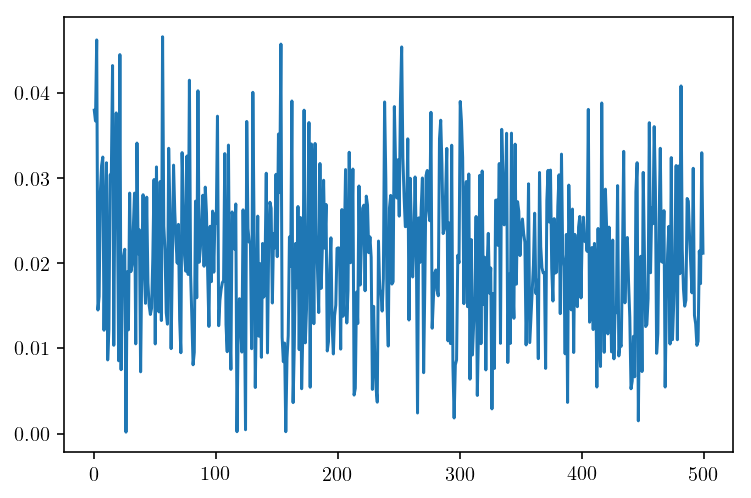

In [7]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
epochs = 20
steps = 0
running_loss = 0
print_every = 1
vec_acc_ = np.zeros(epochs*25)
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Do not forget to transform the inputs and outputs into Variable        #
        # which pytorch uses.                                                          #
        ################################################################################
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        output = net.forward(inputs)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        loss = criterion(output, targets)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        grad = loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            sum_accuracy = 0
            for ii, (images, labels) in enumerate(valloader):
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                
                inputs = Variable(images)
                targets = Variable(labels)
                predicted = net.predict(inputs)
                accuracy = criterion(predicted, targets)
                accuracy = accuracy.data.numpy().tolist()[0]
                #vec_acc_[steps-1] = accuracy/(ii+1)
                sum_accuracy += accuracy
                
                #inputs = Variable(images, volatile=True)
                #predicted = net.predict(inputs)
                #equality = (labels == predicted.max(1)[1])
                #accuracy += equality.type_as(torch.FloatTensor()).mean()
                
                
                #im = Variable(images)
                #out = net.predict(im)
                #_,prediction = torch.max(out, 1)
                #pred_y = prediction.data.numpy().squeeze()
                #target_y = labels.numpy()
                #accuracy = np.mean(predicted == inputs)
                #print(pred_y.shape,target_y.shape)
                
                
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(loss.data[0]),
                  "Test accuracy: {:.4f}..".format(sum_accuracy/(ii+1)),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                  "steps {:.4f}".format(steps)
                 )
            running_loss = 0
            start = time.time()

#plt.plot(range(epochs*25),vec_acc_)
#plt.show()

In [8]:
Vector_create = np.random.rand(1000,38)

In [10]:
vector = np.zeros((len(Vector_create),len(Vector_create[0])))
x = np.zeros((len(Vector_create),18))
y = np.zeros((len(Vector_create),18))
x_train = np.zeros((len(Vector_create)-20,18))
Y_train = np.zeros((len(Vector_create)-20,18))
x_val = np.zeros((20,18))
y_val = np.zeros((20,18))

for i in range(len(Vector_create)):
    vector[i][:] = np.reshape(Vector_create[i][:][:],2*19,'C')
for i in range(len(vector)):
    x[i][:] = vector[i][:18]
    y[i][:] = vector[i][20:38]

mask = list(range(len(vector)-50, len(vector)))
x_val = x[mask]
y_val = y[mask]
mask = list(range(len(vector)-50))
x_train = x[mask]
y_train = y[mask]

x_train,y_train = torch.from_numpy(x_train).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.FloatTensor)
x_val,y_val = torch.from_numpy(x_val).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.FloatTensor)

x_train = x_train.unsqueeze(1) # add 1 dimension to the training set
y_train = y_train.unsqueeze(1) # add 1 dimension to the training set
x_val = x_val.unsqueeze(1) # add 1 dimension to the validation set
y_val = y_val.unsqueeze(1) # add 1 dimension to the validation set

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)

traindataset = utils.TensorDataset(x_train, y_train)
trainloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

valdataset = utils.TensorDataset(x_val, y_val)
valloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

Train data shape:  torch.Size([950, 1, 18])
Train labels shape:  torch.Size([950, 1, 18])
Validation data shape:  torch.Size([50, 1, 18])
Validation labels shape:  torch.Size([50, 1, 18])


In [11]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=1, n_output=None):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        
        self.conv1 = nn.Conv1d(n_input_channels,8,5,padding=2)
        self.conv2 = nn.Conv1d(8,30,3,padding=1)
        self.conv3 = nn.Conv1d(30,40,3,padding=1)
        self.conv3_bn = nn.BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True)
     
        self.fc1 = nn.Linear(9*2 * 40, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 18)
        
        
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Variable `x` with `x.view`.                                                  #
        ################################################################################
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = x.view(-1, 9*2 * 40) # in order to reshape the tensor for as many columns we need
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

In [12]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
epochs = 100
steps = 0
running_loss = 0
print_every = 1
vec_acc_ = np.zeros(epochs*25)
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Do not forget to transform the inputs and outputs into Variable        #
        # which pytorch uses.                                                          #
        ################################################################################
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        output = net.forward(inputs)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        loss = criterion(output, targets)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        grad = loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            sum_accuracy = 0
            for ii, (images, labels) in enumerate(valloader):
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                
                inputs = Variable(images)
                targets = Variable(labels)
                predicted = net.predict(inputs)
                accuracy = criterion(predicted, targets)
                accuracy = accuracy.data.numpy().tolist()[0]
                #vec_acc_[steps-1] = accuracy/(ii+1)
                sum_accuracy += accuracy
                
                #inputs = Variable(images, volatile=True)
                #predicted = net.predict(inputs)
                #equality = (labels == predicted.max(1)[1])
                #accuracy += equality.type_as(torch.FloatTensor()).mean()
                
                
                #im = Variable(images)
                #out = net.predict(im)
                #_,prediction = torch.max(out, 1)
                #pred_y = prediction.data.numpy().squeeze()
                #target_y = labels.numpy()
                #accuracy = np.mean(predicted == inputs)
                #print(pred_y.shape,target_y.shape)
                
                
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(loss.data[0]),
                  "Test accuracy: {:.4f}..".format(sum_accuracy/(ii+1)),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                  "steps {:.4f}".format(steps)
                 )
            running_loss = 0
            start = time.time()



/Users/4romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/100.. Loss: 0.3494.. Test accuracy: 0.2789.. 0.0134 s/batch  steps 1.0000
Epoch: 1/100.. Loss: 0.3129.. Test accuracy: 0.2789.. 0.0111 s/batch  steps 2.0000
Epoch: 1/100.. Loss: 0.2940.. Test accuracy: 0.2789.. 0.0111 s/batch  steps 3.0000
Epoch: 1/100.. Loss: 0.3234.. Test accuracy: 0.2789.. 0.0095 s/batch  steps 4.0000
Epoch: 1/100.. Loss: 0.3431.. Test accuracy: 0.2789.. 0.0116 s/batch  steps 5.0000
Epoch: 1/100.. Loss: 0.2822.. Test accuracy: 0.2789.. 0.0092 s/batch  steps 6.0000
Epoch: 1/100.. Loss: 0.2989.. Test accuracy: 0.2789.. 0.0151 s/batch  steps 7.0000
Epoch: 1/100.. Loss: 0.2930.. Test accuracy: 0.2789.. 0.0119 s/batch  steps 8.0000
Epoch: 1/100.. Loss: 0.2666.. Test accuracy: 0.2789.. 0.0093 s/batch  steps 9.0000
Epoch: 1/100.. Loss: 0.2837.. Test accuracy: 0.2789.. 0.0095 s/batch  steps 10.0000
Epoch: 1/100.. Loss: 0.3118.. Test accuracy: 0.2789.. 0.0105 s/batch  steps 11.0000
Epoch: 1/100.. Loss: 0.2884.. Test accuracy: 0.2789.. 0.0098 s/batch  steps 12.0000
E

Epoch: 1/100.. Loss: 0.0876.. Test accuracy: 0.2789.. 0.0097 s/batch  steps 99.0000
Epoch: 1/100.. Loss: 0.0728.. Test accuracy: 0.2789.. 0.0109 s/batch  steps 100.0000
Epoch: 1/100.. Loss: 0.0858.. Test accuracy: 0.2788.. 0.0112 s/batch  steps 101.0000
Epoch: 1/100.. Loss: 0.0746.. Test accuracy: 0.2788.. 0.0153 s/batch  steps 102.0000
Epoch: 1/100.. Loss: 0.0785.. Test accuracy: 0.2788.. 0.0124 s/batch  steps 103.0000
Epoch: 1/100.. Loss: 0.0879.. Test accuracy: 0.2788.. 0.0090 s/batch  steps 104.0000
Epoch: 1/100.. Loss: 0.0794.. Test accuracy: 0.2788.. 0.0084 s/batch  steps 105.0000
Epoch: 1/100.. Loss: 0.0865.. Test accuracy: 0.2788.. 0.0110 s/batch  steps 106.0000
Epoch: 1/100.. Loss: 0.0834.. Test accuracy: 0.2788.. 0.0098 s/batch  steps 107.0000
Epoch: 1/100.. Loss: 0.0836.. Test accuracy: 0.2788.. 0.0107 s/batch  steps 108.0000
Epoch: 1/100.. Loss: 0.0973.. Test accuracy: 0.2788.. 0.0099 s/batch  steps 109.0000
Epoch: 1/100.. Loss: 0.0990.. Test accuracy: 0.2788.. 0.0125 s/bat

Epoch: 2/100.. Loss: 0.0873.. Test accuracy: 0.2788.. 0.0097 s/batch  steps 196.0000
Epoch: 2/100.. Loss: 0.0884.. Test accuracy: 0.2788.. 0.0083 s/batch  steps 197.0000
Epoch: 2/100.. Loss: 0.0828.. Test accuracy: 0.2788.. 0.0080 s/batch  steps 198.0000
Epoch: 2/100.. Loss: 0.0880.. Test accuracy: 0.2788.. 0.0103 s/batch  steps 199.0000
Epoch: 2/100.. Loss: 0.0829.. Test accuracy: 0.2788.. 0.0099 s/batch  steps 200.0000
Epoch: 2/100.. Loss: 0.0745.. Test accuracy: 0.2788.. 0.0123 s/batch  steps 201.0000
Epoch: 2/100.. Loss: 0.0796.. Test accuracy: 0.2788.. 0.0118 s/batch  steps 202.0000
Epoch: 2/100.. Loss: 0.0934.. Test accuracy: 0.2788.. 0.0109 s/batch  steps 203.0000
Epoch: 2/100.. Loss: 0.0885.. Test accuracy: 0.2788.. 0.0104 s/batch  steps 204.0000
Epoch: 2/100.. Loss: 0.0722.. Test accuracy: 0.2788.. 0.0101 s/batch  steps 205.0000
Epoch: 2/100.. Loss: 0.0799.. Test accuracy: 0.2788.. 0.0123 s/batch  steps 206.0000
Epoch: 2/100.. Loss: 0.0740.. Test accuracy: 0.2788.. 0.0158 s/ba

Epoch: 2/100.. Loss: 0.0749.. Test accuracy: 0.2788.. 0.0098 s/batch  steps 293.0000
Epoch: 2/100.. Loss: 0.0922.. Test accuracy: 0.2788.. 0.0096 s/batch  steps 294.0000
Epoch: 2/100.. Loss: 0.0889.. Test accuracy: 0.2788.. 0.0096 s/batch  steps 295.0000
Epoch: 2/100.. Loss: 0.0867.. Test accuracy: 0.2788.. 0.0100 s/batch  steps 296.0000
Epoch: 2/100.. Loss: 0.0745.. Test accuracy: 0.2788.. 0.0094 s/batch  steps 297.0000
Epoch: 2/100.. Loss: 0.0858.. Test accuracy: 0.2788.. 0.0095 s/batch  steps 298.0000
Epoch: 2/100.. Loss: 0.0894.. Test accuracy: 0.2788.. 0.0105 s/batch  steps 299.0000
Epoch: 2/100.. Loss: 0.0701.. Test accuracy: 0.2788.. 0.0116 s/batch  steps 300.0000
Epoch: 2/100.. Loss: 0.0781.. Test accuracy: 0.2788.. 0.0093 s/batch  steps 301.0000
Epoch: 2/100.. Loss: 0.0836.. Test accuracy: 0.2788.. 0.0096 s/batch  steps 302.0000
Epoch: 2/100.. Loss: 0.0861.. Test accuracy: 0.2788.. 0.0107 s/batch  steps 303.0000
Epoch: 2/100.. Loss: 0.0823.. Test accuracy: 0.2788.. 0.0101 s/ba

Epoch: 3/100.. Loss: 0.0893.. Test accuracy: 0.2787.. 0.0095 s/batch  steps 390.0000
Epoch: 3/100.. Loss: 0.0649.. Test accuracy: 0.2787.. 0.0097 s/batch  steps 391.0000
Epoch: 3/100.. Loss: 0.0732.. Test accuracy: 0.2787.. 0.0092 s/batch  steps 392.0000
Epoch: 3/100.. Loss: 0.0783.. Test accuracy: 0.2787.. 0.0129 s/batch  steps 393.0000
Epoch: 3/100.. Loss: 0.0822.. Test accuracy: 0.2787.. 0.0099 s/batch  steps 394.0000
Epoch: 3/100.. Loss: 0.0863.. Test accuracy: 0.2787.. 0.0092 s/batch  steps 395.0000
Epoch: 3/100.. Loss: 0.0802.. Test accuracy: 0.2787.. 0.0094 s/batch  steps 396.0000
Epoch: 3/100.. Loss: 0.0750.. Test accuracy: 0.2787.. 0.0109 s/batch  steps 397.0000
Epoch: 3/100.. Loss: 0.0690.. Test accuracy: 0.2787.. 0.0086 s/batch  steps 398.0000
Epoch: 3/100.. Loss: 0.0847.. Test accuracy: 0.2787.. 0.0148 s/batch  steps 399.0000
Epoch: 3/100.. Loss: 0.0736.. Test accuracy: 0.2787.. 0.0094 s/batch  steps 400.0000
Epoch: 3/100.. Loss: 0.0926.. Test accuracy: 0.2787.. 0.0087 s/ba

Epoch: 3/100.. Loss: 0.0908.. Test accuracy: 0.2787.. 0.0100 s/batch  steps 487.0000
Epoch: 3/100.. Loss: 0.0947.. Test accuracy: 0.2787.. 0.0107 s/batch  steps 488.0000
Epoch: 3/100.. Loss: 0.0871.. Test accuracy: 0.2787.. 0.0128 s/batch  steps 489.0000
Epoch: 3/100.. Loss: 0.0790.. Test accuracy: 0.2787.. 0.0104 s/batch  steps 490.0000
Epoch: 3/100.. Loss: 0.0747.. Test accuracy: 0.2787.. 0.0114 s/batch  steps 491.0000
Epoch: 3/100.. Loss: 0.0805.. Test accuracy: 0.2787.. 0.0096 s/batch  steps 492.0000
Epoch: 3/100.. Loss: 0.0807.. Test accuracy: 0.2787.. 0.0113 s/batch  steps 493.0000
Epoch: 3/100.. Loss: 0.0896.. Test accuracy: 0.2787.. 0.0182 s/batch  steps 494.0000
Epoch: 3/100.. Loss: 0.0762.. Test accuracy: 0.2787.. 0.0113 s/batch  steps 495.0000
Epoch: 3/100.. Loss: 0.0971.. Test accuracy: 0.2787.. 0.0119 s/batch  steps 496.0000
Epoch: 3/100.. Loss: 0.0692.. Test accuracy: 0.2787.. 0.0104 s/batch  steps 497.0000
Epoch: 3/100.. Loss: 0.0834.. Test accuracy: 0.2787.. 0.0107 s/ba

Epoch: 4/100.. Loss: 0.0726.. Test accuracy: 0.2787.. 0.0107 s/batch  steps 584.0000
Epoch: 4/100.. Loss: 0.0910.. Test accuracy: 0.2787.. 0.0099 s/batch  steps 585.0000
Epoch: 4/100.. Loss: 0.0849.. Test accuracy: 0.2787.. 0.0108 s/batch  steps 586.0000
Epoch: 4/100.. Loss: 0.0744.. Test accuracy: 0.2787.. 0.0098 s/batch  steps 587.0000
Epoch: 4/100.. Loss: 0.0815.. Test accuracy: 0.2787.. 0.0103 s/batch  steps 588.0000
Epoch: 4/100.. Loss: 0.0873.. Test accuracy: 0.2787.. 0.0090 s/batch  steps 589.0000
Epoch: 4/100.. Loss: 0.0748.. Test accuracy: 0.2787.. 0.0132 s/batch  steps 590.0000
Epoch: 4/100.. Loss: 0.0722.. Test accuracy: 0.2787.. 0.0104 s/batch  steps 591.0000
Epoch: 4/100.. Loss: 0.0789.. Test accuracy: 0.2787.. 0.0140 s/batch  steps 592.0000
Epoch: 4/100.. Loss: 0.0863.. Test accuracy: 0.2787.. 0.0121 s/batch  steps 593.0000
Epoch: 4/100.. Loss: 0.0975.. Test accuracy: 0.2787.. 0.0097 s/batch  steps 594.0000
Epoch: 4/100.. Loss: 0.0858.. Test accuracy: 0.2787.. 0.0100 s/ba

Epoch: 4/100.. Loss: 0.0944.. Test accuracy: 0.2786.. 0.0100 s/batch  steps 681.0000
Epoch: 4/100.. Loss: 0.0753.. Test accuracy: 0.2786.. 0.0099 s/batch  steps 682.0000
Epoch: 4/100.. Loss: 0.0822.. Test accuracy: 0.2786.. 0.0106 s/batch  steps 683.0000
Epoch: 4/100.. Loss: 0.0752.. Test accuracy: 0.2786.. 0.0105 s/batch  steps 684.0000
Epoch: 4/100.. Loss: 0.0892.. Test accuracy: 0.2786.. 0.0109 s/batch  steps 685.0000
Epoch: 4/100.. Loss: 0.0883.. Test accuracy: 0.2786.. 0.0114 s/batch  steps 686.0000
Epoch: 4/100.. Loss: 0.0846.. Test accuracy: 0.2786.. 0.0088 s/batch  steps 687.0000
Epoch: 4/100.. Loss: 0.0796.. Test accuracy: 0.2786.. 0.0104 s/batch  steps 688.0000
Epoch: 4/100.. Loss: 0.0873.. Test accuracy: 0.2786.. 0.0100 s/batch  steps 689.0000
Epoch: 4/100.. Loss: 0.0824.. Test accuracy: 0.2786.. 0.0099 s/batch  steps 690.0000
Epoch: 4/100.. Loss: 0.0858.. Test accuracy: 0.2786.. 0.0147 s/batch  steps 691.0000
Epoch: 4/100.. Loss: 0.0882.. Test accuracy: 0.2786.. 0.0115 s/ba

KeyboardInterrupt: 